In [1]:
import os
import subprocess
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
def get_data():
    if os.path.exists("wednesday_nohb.csv"):
        print("-- wednesday.csv found locally")
    df = pd.read_csv("wednesday_nohb.csv", index_col=False)
    return df

In [3]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

In [4]:
data = get_data()

-- wednesday.csv found locally


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
columns = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',]
data.drop(columns, inplace=True, axis=1)
print(data.keys())
print(data.shape[0])
print(data.shape[1])

Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd PSH Flags', u' Fwd URG Flags',
       u' Bwd URG Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packe

In [6]:
df2, targets = encode_target(data, " Label")


In [7]:
df2 = df2.dropna(axis=0, how='any')
df2.isnull().sum().sum()

0

In [8]:
list_unq = (df2.apply(pd.Series.nunique) != 1)
list_unq[list_unq == 0]

 Bwd PSH Flags           False
 Fwd URG Flags           False
 Bwd URG Flags           False
 CWE Flag Count          False
Fwd Avg Bytes/Bulk       False
 Fwd Avg Packets/Bulk    False
 Fwd Avg Bulk Rate       False
 Bwd Avg Bytes/Bulk      False
 Bwd Avg Packets/Bulk    False
Bwd Avg Bulk Rate        False
dtype: bool

In [9]:
df2 = df2.loc[:, df2.apply(pd.Series.nunique) != 1]

In [10]:
features = list(df2.columns[:-2])
y = df2["Target"]
X = df2[features]

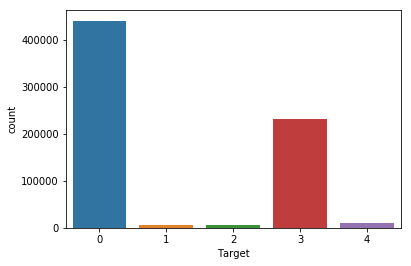

In [11]:
graph = sns.countplot(y ,label="Count")

In [12]:
the_counts = df2["Target"].value_counts()
print(the_counts)

0    439972
3    230124
4     10293
1      5796
2      5499
Name: Target, dtype: int64


In [13]:
del data
del df2

In [14]:
X.head()
X.columns

Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packet Length Variance', u'FIN Flag Count', u' SYN Flag Count',
     

In [15]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [16]:
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]
print(len(to_drop))
print(to_drop)

6
[' SYN Flag Count', ' Avg Fwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', ' Subflow Bwd Packets']


In [17]:
corrMatrix = X.corr()
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_1 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] == 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_1.append(perfect_corr)

In [18]:
for element in result_1:
    print(element)

['Subflow Fwd Packets', ' Total Fwd Packets']
[' Subflow Bwd Packets', ' Total Backward Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' SYN Flag Count', 'Fwd PSH Flags']
[' Fwd Header Length.1', ' Fwd Header Length']


In [19]:
X = X.drop(X[to_drop], axis=1)

In [20]:
X.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,38308,1,1,6,6,6,6,6.000000,0.000000,6,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
1,479,11,5,172,326,79,0,15.636364,31.449238,163,...,4,32,0.0,0.0,0,0,0.0,0.0,0,0
2,1095,10,6,3150,3150,1575,0,315.000000,632.561635,1575,...,3,32,0.0,0.0,0,0,0.0,0.0,0,0
3,15206,17,12,3452,6660,1313,0,203.058824,425.778474,3069,...,10,32,0.0,0.0,0,0,0.0,0.0,0,0
4,1092,9,6,3150,3152,1575,0,350.000000,694.509719,1576,...,2,32,0.0,0.0,0,0,0.0,0.0,0,0


In [21]:
X.isnull().sum().sum()

0

In [22]:
def fix_data_frame(x_train):
    col = x_train.columns[x_train.dtypes.eq(object)]
    x_train[col] = x_train[col].apply(pd.to_numeric, errors='coerce', axis=1)
    return np.nan_to_num(x_train)

In [23]:
def generate_data(x, y, split, seed):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=seed)
    x_train = fix_data_frame(x_train)
    x_test = fix_data_frame(x_test)
    return x_train, x_test, y_train, y_test

In [28]:
def leaning_curve_plot(estimator, X, y, cv):
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Traning Example")
    plt.ylabel("Score")
    plt.grid()
    
    # compute mean and standard deviation
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # fill_between 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    # plotting 
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Trainig score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross Validation score")

    plt.legend(loc="best")
    
    return plt

In [29]:
x_train, x_test, y_train, y_test = generate_data(X, y, 0.3, 21)
values = y_train.value_counts()


In [30]:
the_features = X.columns
del X
del y

In [31]:
std_scaler = StandardScaler().fit(x_train)

#transform train and test set using standardization
x_train_std = std_scaler.transform(x_train)
x_test_std = std_scaler.transform(x_test)

In [32]:
hyper_optimal = {}

In [33]:
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(xgb1, param_grid = {parameter: num_range}, scoring='f1_weighted', verbose=11)
    grid_search.fit(x_train_std, y_train.values)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(1, 2, index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    print("adding parameter ", parameter)
    optimum = df.sort_values([0, 'index'], ascending=[0, 1])[:3]
    val = optimum['index']
    hyper_optimal[parameter] = val
    
    return plot, df

## XGBOOST

In [34]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV 

/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [35]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [36]:
grid_dict = {}
grid_dict['max_depth'] = [6, 7]
grid_dict['n_estimators'] = [295, 300, 305, 310, 315]
grid_dict['min_child_weight'] = [6, 7, 8]
grid_dict['colsample_bytree'] = [0.7, 0.8]
grid_dict['subsample'] = [0.4, 0.9]
#reg_alpha will be 0.005

In [37]:
print(grid_dict)

{'n_estimators': [295, 300, 305, 310, 315], 'subsample': [0.4, 0.9], 'colsample_bytree': [0.7, 0.8], 'max_depth': [6, 7], 'min_child_weight': [6, 7, 8]}


In [38]:
#grid_search = GridSearchCV(xgb1, param_grid=grid_dict, scoring='f1_weighted', verbose=3)
#grid_search.fit(x_train_std, y_train.values)

In [39]:
#from operator import itemgetter
#optimal_parameters = sorted(grid_search.grid_scores_, key=itemgetter(1), reverse=True)[:5][0][0]
#optimal_parameters

In [40]:
final_xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=304,
 max_depth=6,
 min_child_weight=7,
 gamma=0,
 subsample=0.4,
 colsample_bytree=0.9,
 objective= 'multi:softmax', nthreads=-1, reg_alpha=0.005,
 scale_pos_weight=1,
 seed=27, num_class=5, verbose=True)

In [ ]:
final_xgb.fit(x_train_std, y_train.values)

In [ ]:
preds = final_xgb.predict(x_test_std)

In [47]:
print(classification_report(y_test.values, preds))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    131919
          1       1.00      0.99      0.99      1716
          2       0.98      1.00      0.99      1628
          3       1.00      1.00      1.00     69251
          4       1.00      1.00      1.00      2992

avg / total       1.00      1.00      1.00    207506



In [53]:
final_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=7, missing=None, n_estimators=304,
       n_jobs=1, nthread=None, nthreads=-1, num_class=5,
       objective='multi:softprob', random_state=0, reg_alpha=0.005,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.4, verbose=True)

In [ ]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(int(len(x_train_std)), n_iter=10, random_state=21, test_size=0.2)
plt = leaning_curve_plot(final_xgb, x_train_std, y_train.values, cv)
plt.savefig("xgboost_learning.png")


In [ ]:
import cPickle

In [50]:
with open('xg_boost', 'wb') as f:
    cPickle.dump(final_xgb, f)


In [51]:
with open('xg_boost', 'rb') as f:
    rf = cPickle.load(f)


In [54]:
print(classification_report(y_test.values, rf.predict(x_test_std)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    131919
          1       1.00      0.99      0.99      1716
          2       0.98      1.00      0.99      1628
          3       1.00      1.00      1.00     69251
          4       1.00      1.00      1.00      2992

avg / total       1.00      1.00      1.00    207506



In [55]:
from xgboost import plot_importance

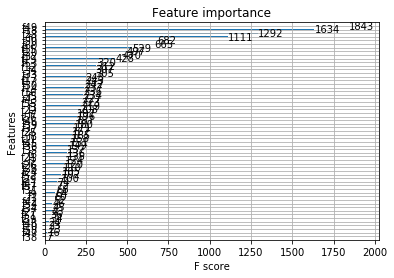

In [57]:
plot_importance(final_xgb)

plt.show()

In [58]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

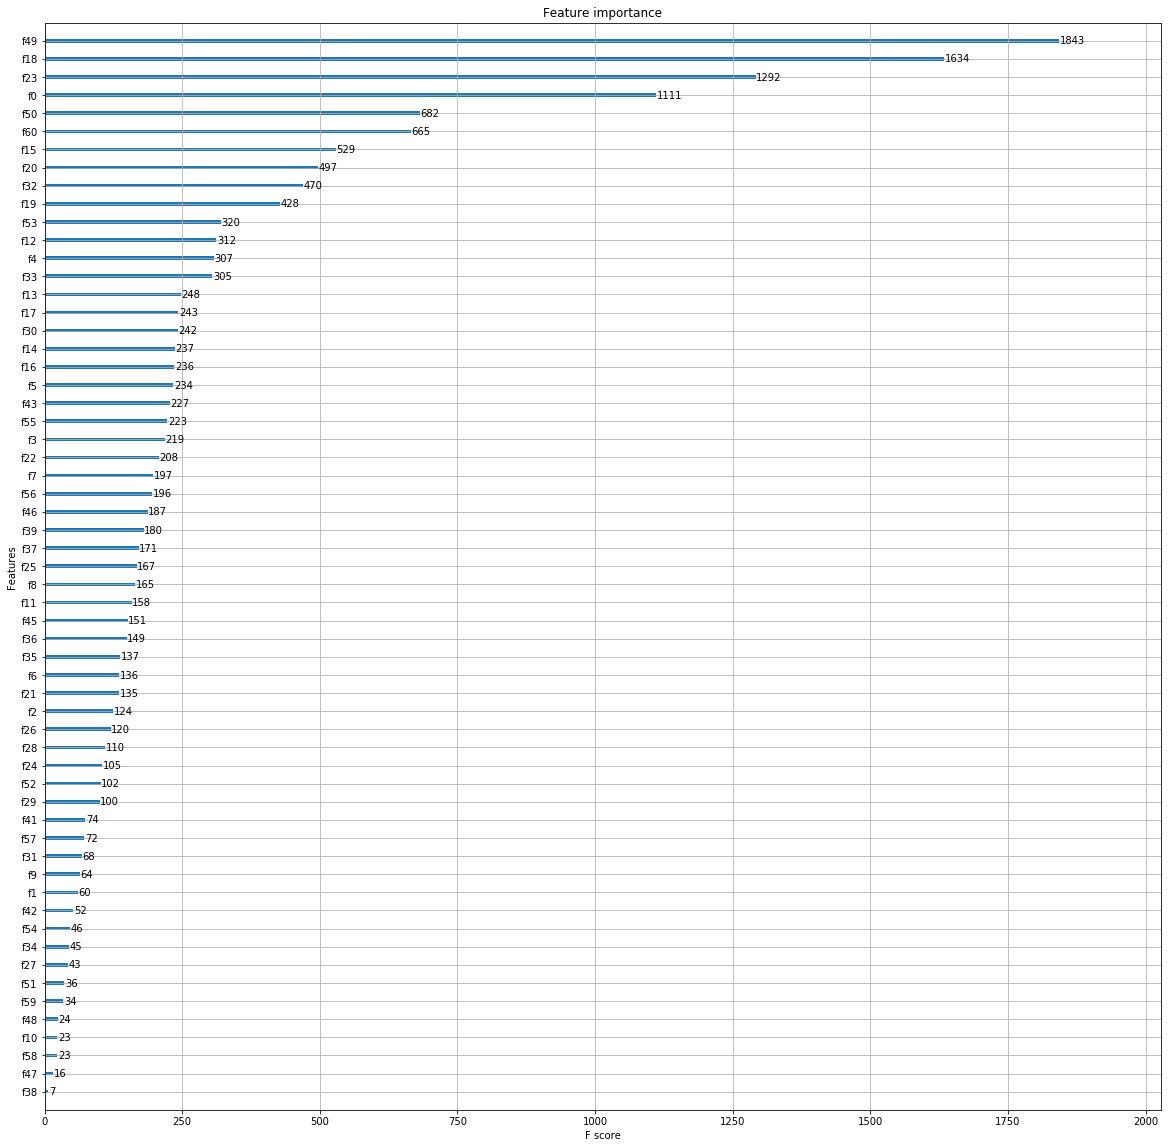

In [59]:
my_plot_importance(final_xgb, (20,20))

In [76]:
some_zip = zip(final_xgb.feature_importances_, the_features)

In [79]:
some_zip.sort(key= lambda x : x[0], reverse=True)

In [80]:
some_zip

[(0.11384273, 'Init_Win_bytes_forward'),
 (0.10093273, ' Flow IAT Min'),
 (0.079807274, ' Fwd IAT Min'),
 (0.06862684, ' Flow Duration'),
 (0.04212737, ' Init_Win_bytes_backward'),
 (0.041077275, ' Idle Min'),
 (0.03267651, ' Flow IAT Mean'),
 (0.030699858, ' Fwd IAT Mean'),
 (0.029032059, 'Fwd Packets/s'),
 (0.026437705, 'Fwd IAT Total'),
 (0.019766508, 'Active Mean'),
 (0.019272346, ' Bwd Packet Length Std'),
 (0.018963493, ' Total Length of Bwd Packets'),
 (0.018839953, ' Bwd Packets/s'),
 (0.015319044, 'Flow Bytes/s'),
 (0.015010192, ' Flow IAT Max'),
 (0.014948422, ' Fwd Header Length'),
 (0.01463957, ' Flow Packets/s'),
 (0.0145777995, ' Flow IAT Std'),
 (0.014454259, ' Fwd Packet Length Max'),
 (0.014021867, ' URG Flag Count'),
 (0.013774785, ' Active Max'),
 (0.013527704, 'Total Length of Fwd Packets'),
 (0.01284823, ' Fwd IAT Max'),
 (0.012168757, ' Fwd Packet Length Mean'),
 (0.012106986, ' Active Min'),
 (0.011551053, ' Average Packet Size'),
 (0.011118661, 'FIN Flag Count')

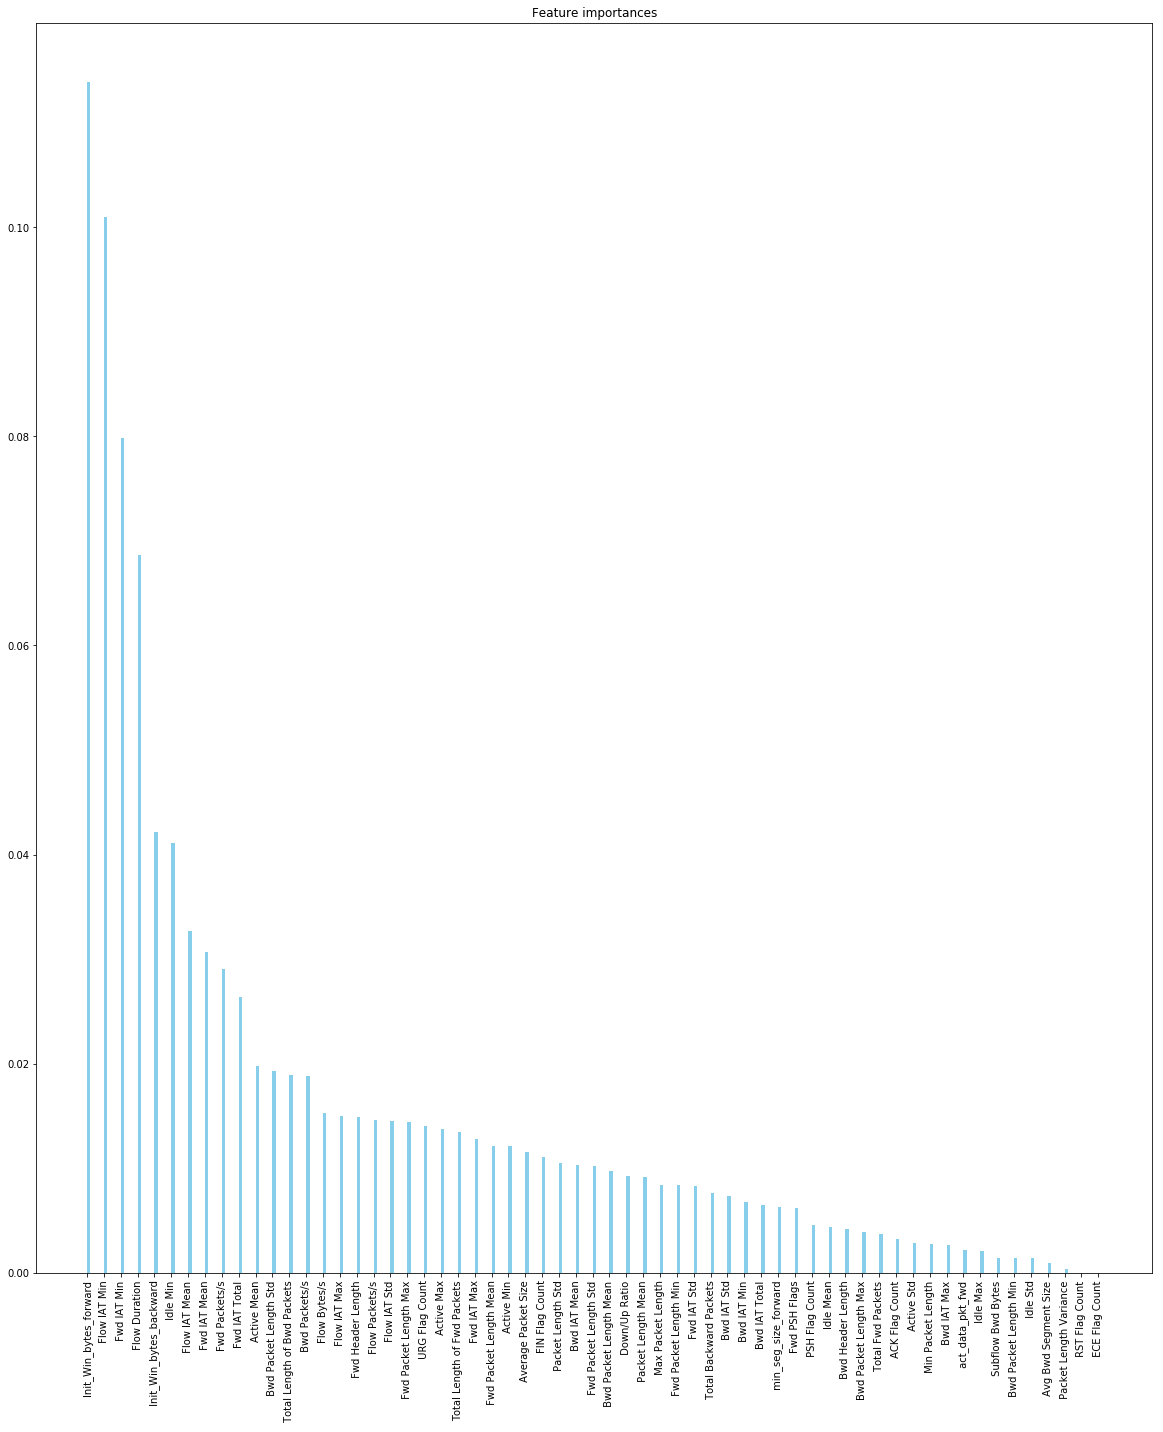

In [90]:
k_x = [x[1] for x in some_zip]
k_y = [x[0] for x in some_zip]
plt.figure(1, figsize=(20, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), k_y, 0.2,
       color="skyblue", align="edge")
plt.xticks(range(x_train.shape[1]), k_x,rotation=90)
plt.savefig("xgb_kbest.png")

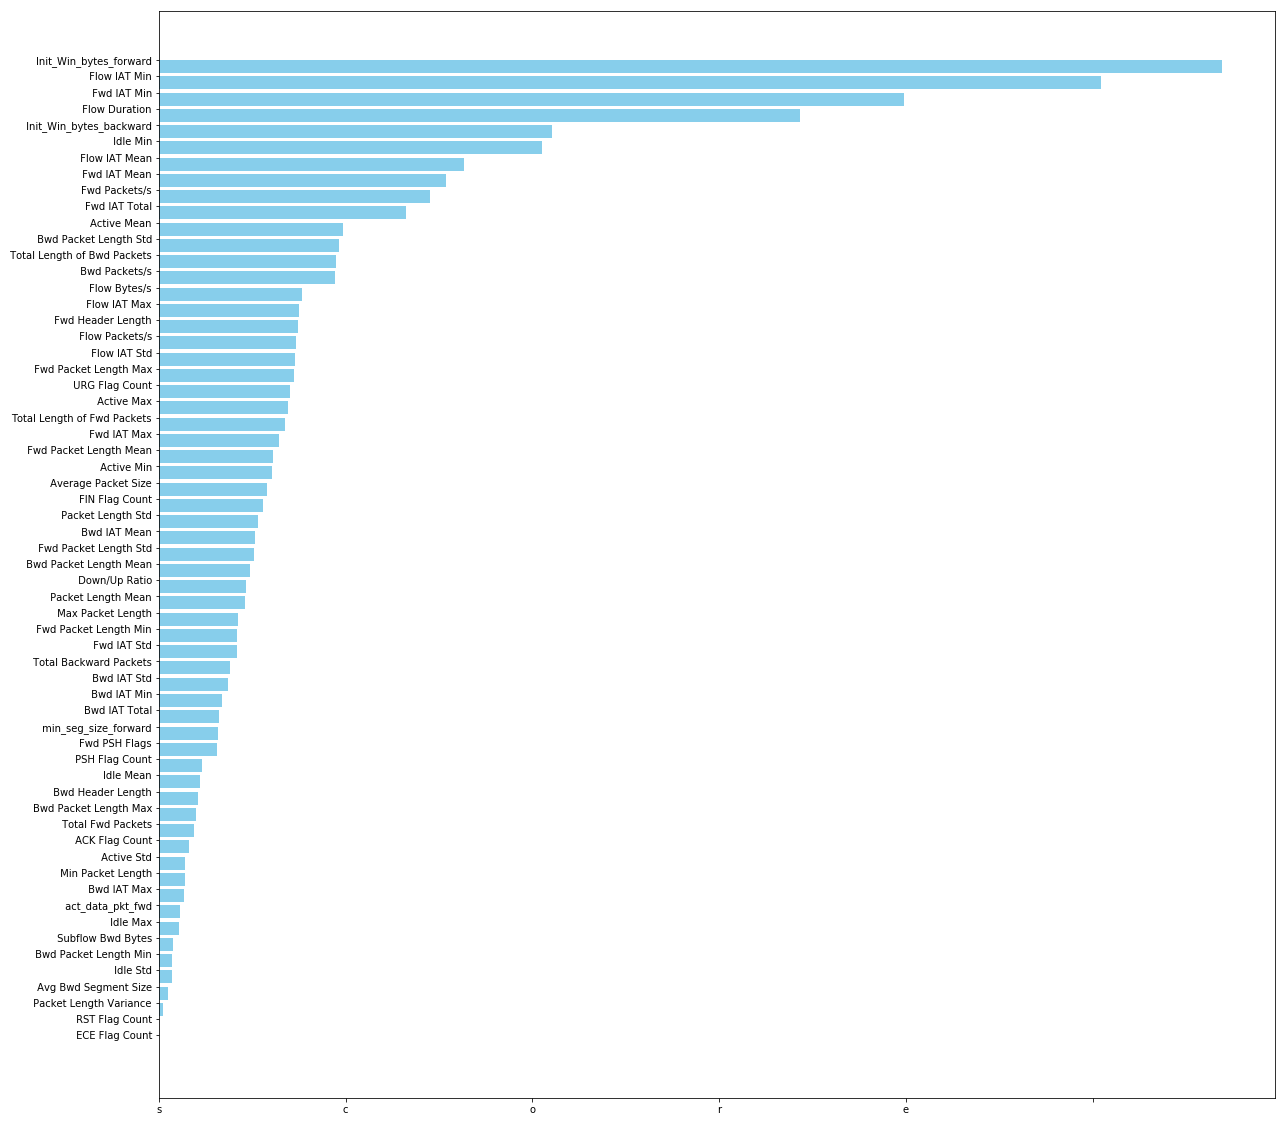

In [115]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.barh(k_x, k_y, align='edge', color='skyblue', ecolor='black')
ax.set_yticks(np.arange(len(k_x)))
ax.set_yticklabels(k_x)
ax.set_xticklabels("score")
ax.invert_yaxis()  # labels read top-to-bottom
fig.savefig("hmm_xgb_kbest.png")